In [14]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression

from p4_generate_dataset import SAMPLE_ELOS

In [15]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.head()

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
0,2kr1bnr/ppp1pppp/2n5/3q4/6b1/5N2/PPPPBPPP/RNBQ...,b1c3,1837.177419,0.451613,62,h2h3,-1.359744,-0.726275,1.157068,-0.309651,...,b1c3,True,False,b1c3,True,b1c3,True,-0.726275,b1c3,True
1,2kr1bnr/pppbpppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1BQ...,f1e1,1400.066667,0.550000,60,d2d4,-3.224526,-1.224806,1.050605,-1.132909,...,f1e1,True,False,f1e1,True,f1e1,True,-1.224806,f1e1,True
2,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,d2d4,1296.660714,0.625000,112,d2d4,-6.772500,0.619760,0.516072,-1.878889,...,d2d4,True,True,e1g1,False,d2d4,True,0.619760,d2d4,True
3,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,e1g1,1317.025455,0.603636,275,d2d4,-6.772500,-0.402230,0.998686,-2.058681,...,d2d4,True,True,e1g1,False,d2d4,True,-0.402230,d2d4,True
4,r1b1kb1r/ppp1pppp/2n2n2/3q4/8/5N2/PPPPBPPP/RNB...,e1g1,1626.631579,0.438596,57,e1g1,-4.251203,0.594833,1.210148,-0.815407,...,e1g1,True,True,e1g1,True,e1g1,True,0.594833,e1g1,True


In [16]:
df.describe()

,avg_elo,global_winrate,count,fragility_score,delta,variance,score_base,winrate_500,score_500,mix_score_500,...,mix_score_850,winrate_1200,score_1200,mix_score_1200,winrate_1500,score_1500,mix_score_1500,winrate_2200,score_2200,mix_score_2200
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,1532.871038,0.476793,531.174897,0.062248,-0.301498,0.695992,0.152247,0.132313,0.152247,-0.119625,...,-0.119625,0.471575,0.152247,-0.155999,0.480479,0.152247,-0.210561,0.402570,0.152247,-0.301498
std,188.159047,0.081600,2980.339144,1.446897,1.513894,1.984717,1.067371,0.301689,1.067371,1.040042,...,1.040042,0.153756,1.067371,1.070497,0.105495,1.067371,1.187026,0.312500,1.067371,1.513894
min,1128.297297,0.040000,50.000000,-6.772500,-11.768746,-28.416490,-10.852399,0.000000,-10.852399,-5.673760,...,-5.673760,0.000000,-10.852399,-6.892757,0.000000,-10.852399,-8.721253,0.000000,-10.852399,-11.768746
25%,1377.616828,0.430551,65.000000,-0.738151,-0.794823,0.971994,-0.098293,0.000000,-0.098293,-0.554214,...,-0.554214,0.388889,-0.098293,-0.576665,0.421053,-0.098293,-0.631766,0.000000,-0.098293,-0.794823
50%,1530.909284,0.479279,105.000000,0.446059,0.196008,1.208849,0.414564,0.000000,0.414564,0.105591,...,0.105591,0.473684,0.414564,0.091809,0.480000,0.414564,0.072912,0.428571,0.414564,0.196008
75%,1692.551379,0.519960,208.250000,1.189489,0.594833,1.265648,0.760919,0.000000,0.760919,0.593329,...,0.593329,0.545982,0.760919,0.546619,0.533381,0.760919,0.518053,0.569876,0.760919,0.594833
max,1963.800000,0.941176,35816.000000,1.645392,2.090428,1.292698,1.410115,1.000000,1.410115,1.496782,...,1.496782,1.000000,1.410115,1.615511,1.000000,1.410115,1.793605,1.000000,1.410115,2.090428


In [17]:
results = []
grouped = df.groupby("fen").first().reset_index()

for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_frag_col = f"is_frag_best_{elo}"
    is_delta_col = f"is_delta_best_{elo}"
    is_mix_col = f"is_mix_best_{elo}"

    avg_is_best = grouped[is_best_col].mean()
    avg_is_engine_best = grouped[is_engine_col].mean()
    avg_is_frag_best = grouped[is_frag_col].mean()
    avg_is_delta_best = grouped[is_delta_col].mean()
    avg_is_mix_best = grouped[is_mix_col].mean()

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_frag_best": avg_is_frag_best,
        "avg_is_delta_best": avg_is_delta_best,
        "avg_is_mix_best": avg_is_mix_best,
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_frag_best,avg_is_delta_best,avg_is_mix_best
0,500,0.751004,0.389558,0.931727,0.746988,0.746988
1,850,0.759036,0.405622,0.763052,0.763052,0.763052
2,1200,0.775100,0.401606,0.751004,0.759036,0.759036
3,1500,0.783133,0.417671,0.730924,0.783133,0.783133
4,2200,0.783133,0.393574,0.779116,0.767068,0.767068


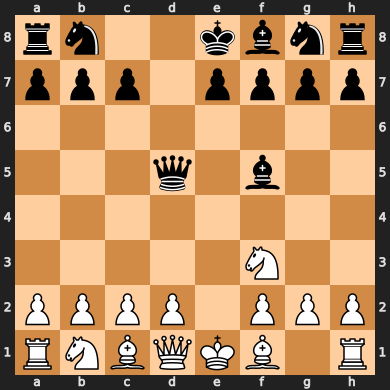

In [18]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [19]:
filtered

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
92,rn2kbnr/ppp1pppp/8/3q1b2/8/5N2/PPPP1PPP/RNBQKB...,b1c3,1591.586466,0.526316,133,f1e2,0.847263,0.943805,0.848687,0.879918,...,f1e2,True,True,d2d4,False,b1c3,False,0.943805,b1c3,False
93,rn2kbnr/ppp1pppp/8/3q1b2/8/5N2/PPPP1PPP/RNBQKB...,d2d4,1746.322581,0.548387,62,f1e2,0.847263,-0.900761,1.103480,0.349994,...,f1e2,True,True,d2d4,False,b1c3,False,-0.900761,b1c3,False
94,rn2kbnr/ppp1pppp/8/3q1b2/8/5N2/PPPP1PPP/RNBQKB...,f1e2,1700.217391,0.643478,115,f1e2,0.847263,0.719466,1.271667,0.946132,...,f1e2,True,True,d2d4,False,b1c3,False,0.719466,b1c3,False


# Regression Analysis

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    486 non-null    object 
 1   next_move              486 non-null    object 
 2   avg_elo                486 non-null    float64
 3   global_winrate         486 non-null    float64
 4   count                  486 non-null    int64  
 5   engine_move            486 non-null    object 
 6   fragility_score        486 non-null    float64
 7   delta                  486 non-null    float64
 8   variance               486 non-null    float64
 9   score_base             486 non-null    float64
 10  winrate_500            486 non-null    float64
 11  historical_best_500    486 non-null    object 
 12  score_500              486 non-null    float64
 13  recommended_move_500   486 non-null    object 
 14  is_best_500            486 non-null    bool   
 15  is_eng

In [21]:
# df["f_cross_d"] = df["fragility_score"] * df["delta"]
# df["f_cross_v"] = df["fragility_score"] * df["variance"]
# df["d_cross_v"] = df["delta"] * df["variance"]

selected_features = ["fragility_score", "delta", "variance", "score_base"] #"f_cross_d", "f_cross_v", "d_cross_v", ]
X = df[selected_features]
y = df["is_best_1500"]

# train test split
# accuracy

In [22]:
model = LinearRegression() # logistic regression
model.fit(X, y)

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")

fragility_score: -0.026
delta: 0.056
variance: -0.006
score_base: 0.008


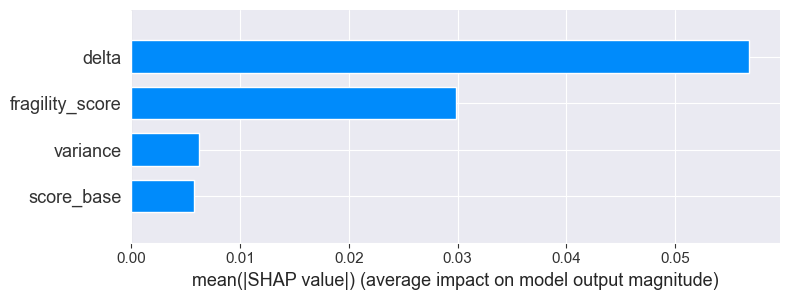

In [23]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")

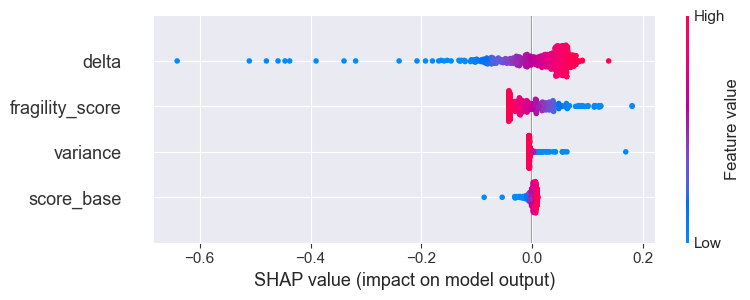

In [24]:
shap.summary_plot(shap_values, X, show=True)

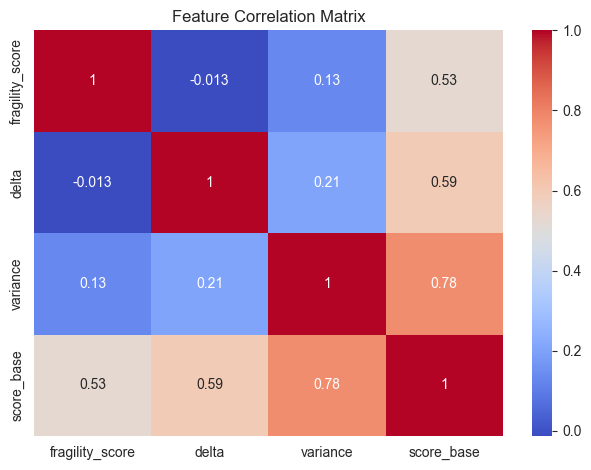

In [25]:
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()